본 강좌에서는 영상인식을 해보겠습니다. 늘 그렇듯이 다음과 같은 순서로 진행하겠습니다.

1. 데이터셋 준비하기
1. 모델 구성하기
1. 모델 엮기
1. 모델 학습시키기
1. 모델 사용하기

---

### 데이터셋 준비하기

The problem of automatically identifying objects in photographs is di cult because of the near infinite number of permutations of objects, positions, lighting and so on. It’s a really hard problem. This is a well studied problem in computer vision and more recently an important demonstration of the capability of deep learning. A standard computer vision and deep learning dataset for this problem was developed by the Canadian Institute for Advanced Research
(CIFAR).
The CIFAR-10 dataset consists of 60,000 photos divided into 10 classes (hence the name
CIFAR-10)1. Classes include common objects such as airplanes, automobiles, birds, cats and so on. The dataset is split in a standard way, where 50,000 images are used for training a model and the remaining 10,000 for evaluating its performance. The photos are in color with red, green and blue channels, but are small measuring 32 ⇥ 32 pixel squares.

The CIFAR-10 dataset can easily be loaded in Keras. Keras has the facility to automatically download standard datasets like CIFAR-10 and store them in the ~/.keras/datasets directory using the cifar10.load data() function. This dataset is large at 163 megabytes, so it may take a few minutes to download. Once downloaded, subsequent calls to the function will load the dataset ready for use.
The dataset is stored as Python pickled training and test sets, ready for use in Keras. Each image is represented as a three dimensional matrix, with dimensions for red, green, blue, width and height. We can plot images directly using the Matplotlib Python plotting library.

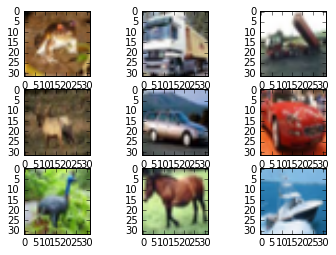

In [9]:
from keras.datasets import cifar10
from keras.utils import np_utils
from matplotlib import pyplot
%matplotlib inline 

from scipy.misc import toimage
# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# create a grid of 3x3 images
for i in range(0, 9):
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(toimage(X_train[i]))
# show the plot
pyplot.show()

# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype( 'float32' )
X_test = X_test.astype( 'float32' )
X_train = X_train / 255.0
X_test = X_test / 255.0

# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

![svg]({{ site.baseurl }}/posts_warehouse/2017-2-4-CNN_Getting_Started-1.png)

In [10]:
# Simple CNN model for CIFAR-10
import numpy
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D

from keras import backend as K
K.set_image_dim_ordering('th')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

Next we need to load the MNIST dataset and reshape it so that it is suitable for use training a CNN. In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [channels][width][height]. In the case of RGB, the first dimension channels would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In the case of MNIST where the channels values are gray scale, the pixel dimension is set to 1.

---

### 모델 구성하기

Next we define our neural network model. Convolutional neural networks are more complex than standard Multilayer Perceptrons, so we will start by using a simple structure to begin with that uses all of the elements for state-of-the-art results. Below summarizes the network architecture.
1. The first hidden layer is a convolutional layer called a Convolution2D. The layer has 32 feature maps, which with the size of 5 ⇥ 5 and a rectifier activation function. This is the input layer, expecting images with the structure outline above.
2. Next we define a pooling layer that takes the maximum value called MaxPooling2D. It is configured with a pool size of 2 ⇥ 2.
3. The next layer is a regularization layer using dropout called Dropout. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.
4. Next is a layer that converts the 2D matrix data to a vector called Flatten. It allows the output to be processed by standard fully connected layers.
5. Next a fully connected layer with 128 neurons and rectifier activation function is used.
6. Finally, the output layer has 10 neurons for the 10 classes and a softmax activation function to output probability-like predictions for each class.
As before, the model is trained using logarithmic loss and the ADAM gradient descent algorithm. A depiction of the network structure is provided below.

In [11]:
# Create the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(3, 32, 32), border_mode= 'same', activation= 'relu' , W_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Convolution2D(32, 3, 3, activation= 'relu' , border_mode= 'same' , W_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation= 'relu' , W_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation= 'softmax' ))

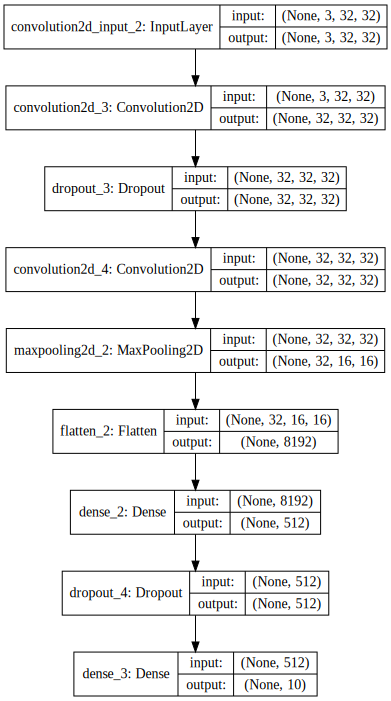

In [12]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

# brew install graphviz
# pip uninstall -y pydot
# pip install pydot-ng

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

![svg]({{ site.baseurl }}/posts_warehouse/2017-2-4-CNN_Getting_Started-2.svg)

### 모델 엮기

컴파일 시에 정의해야하는 것들
- 가중치 세트를 평가하는 데 사용할 손실함수(loss function)
 - binary_crossentropy : 이진 분류를 위한 logarithmic loss
- 네트워크의 다른 가중치를 검객하는 데 사용되는 최적화 알고리즘
 - adam : 효율적인 경사 하강법(gradient descent) 알고리즘
- 학습과정에서 수집하기 싶은 측정 기준

In [13]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 모델 학습시키기

- nb_epoch : 데이터셋에 대한 반복 횟수
- batch_size : 네트워크에서 가중치 개갱신 전에 평가되는 인스턴스의 수

In [14]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=25, batch_size=32,verbose=2)

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
817s - loss: 1.5282 - acc: 0.4469 - val_loss: 1.2116 - val_acc: 0.5784
Epoch 2/25
874s - loss: 1.1790 - acc: 0.5809 - val_loss: 1.1002 - val_acc: 0.6184
Epoch 3/25
852s - loss: 1.0605 - acc: 0.6233 - val_loss: 1.0328 - val_acc: 0.6435
Epoch 4/25
782s - loss: 0.9867 - acc: 0.6516 - val_loss: 0.9449 - val_acc: 0.6718
Epoch 5/25
907s - loss: 0.9363 - acc: 0.6714 - val_loss: 0.9224 - val_acc: 0.6790
Epoch 6/25


KeyboardInterrupt: 

In [ ]:
# evaliuate
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

---

### 같이 보기

* [강좌 목차](https://tykimos.github.io/2017/01/27/Keras_Lecture_Plan/)
* 이전 : [딥러닝 기본 실습/다층 퍼셉트론 모델 만들어보기](https://tykimos.github.io/2017/02/04/MLP_Getting_Started/)
* 다음 : [딥러닝 기본 실습/오토인코더 모델 만들어보기](https://tykimos.github.io/2017/02/04/AutoEncoder_Getting_Started/)